In [2]:
import pandas as pd
# from pandas.plotting import scatter_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import mpld3
%matplotlib inline
# mpld3.enable_notebook()

N_JOBS = 5

In [3]:
datatrain = pd.read_csv('dataset/fraud_train.csv')
datatest = pd.read_csv('dataset/fraud_train.csv')

# Step
1. praprocessing
    1. preparing the preparation
    2. Exploratory Data Analysis
    8. Scalling data
    3. Dealing with Missing Values
    4. Dealing with Outliers
    5. Dealing with Imbalanced Data
    6. Data Transformations
    7. Finishing Touches & Moving Ahead
    8. Choosing feature
2. process
    1. Logistic Regression
    2. Decision Tree
    3. Random Forest
    4. Neural Networks
3. summary and conclutions

## Refference
1. praprocessing 
    1. http://scikit-learn.org/stable/modules/preprocessing.html
    1. https://github.com/pandas-dev/pandas/blob/master/doc/cheatsheet/Pandas_Cheat_Sheet.pdf
    1. https://www.kaggle.com/ekami66/detailed-exploratory-data-analysis-with-python
    1. https://www.kdnuggets.com/2017/06/7-steps-mastering-data-preparation-python.html/2
    1. https://github.com/pandas-profiling/pandas-profiling
    2. https://machinelearningmastery.com/prepare-data-machine-learning-python-scikit-learn/
    3. https://www.geeksforgeeks.org/data-preprocessing-machine-learning-python/
    1. https://www.analyticsvidhya.com/blog/2016/07/practical-guide-data-preprocessing-python-scikit-learn/
    1. https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-1-exploratory-data-analysis-with-pandas-de57880f1a68
    1. https://github.com/ajaymache/data-analysis-using-python
1. process

## 1. Praprocessing

### B. Exploratory Data Analysis

In [ ]:
datatrain.head()

In [ ]:
# datatrain["nama_merchant"].value_counts()
# sns.set(rc={'figure.figsize':(11.7,8.27)})
# ax = sns.countplot(x="nama_merchant", data=datatrain)

# total = len(datatrain)
# for p in ax.patches:
#         ax.annotate('({:.1f}%)'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))

In [ ]:
graphout = datatrain[['flag_transaksi_fraud','tipe_kartu','nama_transaksi','nama_channel']]
fig, axes = plt.subplots(round(len(graphout.columns) / 2), 2, figsize=(12, 12))
total = len(graphout)

for i, ax in enumerate(fig.axes):
    if i < len(graphout.columns):
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
        sns.countplot(x=graphout.columns[i], alpha=0.7, data=graphout, ax=ax)
    for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))

fig.tight_layout()

In [ ]:
# datatrain.corr()

In [ ]:
graphoutscatter = datatrain[['flag_transaksi_fraud','tipe_kartu','nama_transaksi','nama_channel', 'nilai_transaksi']]
# fig, axes = plt.subplots(round(len(graphoutscatter.columns) / 2), 2, figsize=(12, 12))
        
for i in range(0, round(len(graphoutscatter.columns) / 2), 2):
    sns.pairplot(data=graphoutscatter,
                x_vars=graphoutscatter.columns[i:i+5],
                y_vars=['nilai_transaksi'])

In [ ]:
f, ax = plt.subplots(figsize=(15, 15))
corr = datatrain.corr(method='pearson')
# corr = datatrain.corr(method='spearman')

ax = sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax, annot=True, annot_kws={"size": 8}, fmt='.1g')#, cmap='viridis')
ax.set_title('Correlation pearson')

In [ ]:
import pandas_profiling
pandas_profiling.ProfileReport(datatrain)

## B. scalling data

Ref:
1. Rescale data.
2. Standardize data.
3. Normalize data.
4. Binarize data.

code:
1. https://machinelearningmastery.com/prepare-data-machine-learning-python-scikit-learn/
1. https://machinelearningmastery.com/rescaling-data-for-machine-learning-in-python-with-scikit-learn/
1. http://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html
1. http://scikit-learn.org/stable/modules/preprocessing.html

### C. Dealing with Missing Values

1. https://clevertap.com/blog/how-to-treat-missing-values-in-your-data-part-i/
1. https://clevertap.com/blog/how-to-treat-missing-values-in-your-data-part-ii/

#### method
1. delete row (with nan val)
1. average nan from global value
1. predict 

#### tools
1. http://pandas.pydata.org/pandas-docs/stable/missing_data.html
1. http://scikit-learn.org/stable/modules/preprocessing.html#imputation-of-missing-values
1. KNN https://towardsdatascience.com/the-use-of-knn-for-missing-values-cf33d935c637
1. KNN sklearn https://github.com/scikit-learn/scikit-learn/pull/9212
1. KNN keagle https://www.kaggle.com/dan195/knn-imputation-gbregression-an-plsregression

In [ ]:
datatrain.shape

In [ ]:
datatrain.dropna().shape

In [ ]:
datatrain.isnull().values.any()

In [ ]:
datatrain.isnull().sum()#.sum()

In [ ]:
nan_rows = datatrain[datatrain.isnull().T.any().T]
nan_rows

In [ ]:
datatrain.describe()

In [ ]:
datatrain.info() 

##### a. Handling missing value with drop row

In [ ]:
datatrain1 = datatrain.dropna()

In [ ]:
datatrain1 =  datatrain.fillna(0)
datatrain1[datatrain1.isnull().T.any().T]

In [ ]:
# datatrain.count()

In [ ]:
# datatrain.interpolate().count()

##### b. Handling missing value with KNN

In [ ]:
import numpy as np
import pandas as pd
from collections import defaultdict
from scipy.stats import hmean
from scipy.spatial.distance import cdist
from scipy import stats
import numbers


def weighted_hamming(data):
    """ Compute weighted hamming distance on categorical variables. For one variable, it is equal to 1 if
        the values between point A and point B are different, else it is equal the relative frequency of the
        distribution of the value across the variable. For multiple variables, the harmonic mean is computed
        up to a constant factor.
        @params:
            - data = a pandas data frame of categorical variables
        @returns:
            - distance_matrix = a distance matrix with pairwise distance for all attributes
    """
    categories_dist = []
    
    for category in data:
        X = pd.get_dummies(data[category])
        X_mean = X * X.mean()
        X_dot = X_mean.dot(X.transpose())
        X_np = np.asarray(X_dot.replace(0,1,inplace=False))
        categories_dist.append(X_np)
    categories_dist = np.array(categories_dist)
    distances = hmean(categories_dist, axis=0)
    return distances


def distance_matrix(data, numeric_distance = "euclidean", categorical_distance = "jaccard"):
    """ Compute the pairwise distance attribute by attribute in order to account for different variables type:
        - Continuous
        - Categorical
        For ordinal values, provide a numerical representation taking the order into account.
        Categorical variables are transformed into a set of binary ones.
        If both continuous and categorical distance are provided, a Gower-like distance is computed and the numeric
        variables are all normalized in the process.
        If there are missing values, the mean is computed for numerical attributes and the mode for categorical ones.
        
        Note: If weighted-hamming distance is chosen, the computation time increases a lot since it is not coded in C 
        like other distance metrics provided by scipy.
        @params:
            - data                  = pandas dataframe to compute distances on.
            - numeric_distances     = the metric to apply to continuous attributes.
                                      "euclidean" and "cityblock" available.
                                      Default = "euclidean"
            - categorical_distances = the metric to apply to binary attributes.
                                      "jaccard", "hamming", "weighted-hamming" and "euclidean"
                                      available. Default = "jaccard"
        @returns:
            - the distance matrix
    """
    possible_continuous_distances = ["euclidean", "cityblock"]
    possible_binary_distances = ["euclidean", "jaccard", "hamming", "weighted-hamming"]
    number_of_variables = data.shape[1]
    number_of_observations = data.shape[0]

    # Get the type of each attribute (Numeric or categorical)
    is_numeric = [all(isinstance(n, numbers.Number) for n in data.iloc[:, i]) for i, x in enumerate(data)]
    is_all_numeric = sum(is_numeric) == len(is_numeric)
    is_all_categorical = sum(is_numeric) == 0
    is_mixed_type = not is_all_categorical and not is_all_numeric

    # Check the content of the distances parameter
    if numeric_distance not in possible_continuous_distances:
        print ("The continuous distance " + numeric_distance + " is not supported.")
        return None
    elif categorical_distance not in possible_binary_distances:
        print ("The binary distance " + categorical_distance + " is not supported.")
        return None

    # Separate the data frame into categorical and numeric attributes and normalize numeric data
    if is_mixed_type:
        number_of_numeric_var = sum(is_numeric)
        number_of_categorical_var = number_of_variables - number_of_numeric_var
        data_numeric = data.iloc[:, is_numeric]
        data_numeric = (data_numeric - data_numeric.mean()) / (data_numeric.max() - data_numeric.min())
        data_categorical = data.iloc[:, [not x for x in is_numeric]]

    # Replace missing values with column mean for numeric values and mode for categorical ones. With the mode, it
    # triggers a warning: "SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame"
    # but the value are properly replaced
    if is_mixed_type:
        data_numeric.fillna(data_numeric.mean(), inplace=True)
        for x in data_categorical:
            data_categorical[x].fillna(data_categorical[x].mode()[0], inplace=True)
    elif is_all_numeric:
        data.fillna(data.mean(), inplace=True)
    else:
        for x in data:
            data[x].fillna(data[x].mode()[0], inplace=True)

    # "Dummifies" categorical variables in place
    if not is_all_numeric and not (categorical_distance == 'hamming' or categorical_distance == 'weighted-hamming'):
        if is_mixed_type:
            data_categorical = pd.get_dummies(data_categorical)
        else:
            data = pd.get_dummies(data)
    elif not is_all_numeric and categorical_distance == 'hamming':
        if is_mixed_type:
            data_categorical = pd.DataFrame([pd.factorize(data_categorical[x])[0] for x in data_categorical]).transpose()
        else:
            data = pd.DataFrame([pd.factorize(data[x])[0] for x in data]).transpose()

    if is_all_numeric:
        result_matrix = cdist(data, data, metric=numeric_distance)
    elif is_all_categorical:
        if categorical_distance == "weighted-hamming":
            result_matrix = weighted_hamming(data)
        else:
            result_matrix = cdist(data, data, metric=categorical_distance)
    else:
        result_numeric = cdist(data_numeric, data_numeric, metric=numeric_distance)
        if categorical_distance == "weighted-hamming":
            result_categorical = weighted_hamming(data_categorical)
        else:
            result_categorical = cdist(data_categorical, data_categorical, metric=categorical_distance)
        result_matrix = np.array([[1.0*(result_numeric[i, j] * number_of_numeric_var + result_categorical[i, j] *
                               number_of_categorical_var) / number_of_variables for j in range(number_of_observations)] for i in range(number_of_observations)])

    # Fill the diagonal with NaN values
    np.fill_diagonal(result_matrix, np.nan)

    return pd.DataFrame(result_matrix)


def knn_impute(target, attributes, k_neighbors, aggregation_method="mean", numeric_distance="euclidean",
               categorical_distance="jaccard", missing_neighbors_threshold = 0.5):
    """ Replace the missing values within the target variable based on its k nearest neighbors identified with the
        attributes variables. If more than 50% of its neighbors are also missing values, the value is not modified and
        remains missing. If there is a problem in the parameters provided, returns None.
        If to many neighbors also have missing values, leave the missing value of interest unchanged.
        @params:
            - target                        = a vector of n values with missing values that you want to impute. The length has
                                              to be at least n = 3.
            - attributes                    = a data frame of attributes with n rows to match the target variable
            - k_neighbors                   = the number of neighbors to look at to impute the missing values. It has to be a
                                              value between 1 and n.
            - aggregation_method            = how to aggregate the values from the nearest neighbors (mean, median, mode)
                                              Default = "mean"
            - numeric_distances             = the metric to apply to continuous attributes.
                                              "euclidean" and "cityblock" available.
                                              Default = "euclidean"
            - categorical_distances         = the metric to apply to binary attributes.
                                              "jaccard", "hamming", "weighted-hamming" and "euclidean"
                                              available. Default = "jaccard"
            - missing_neighbors_threshold   = minimum of neighbors among the k ones that are not also missing to infer
                                              the correct value. Default = 0.5
        @returns:
            target_completed        = the vector of target values with missing value replaced. If there is a problem
                                      in the parameters, return None
    """

    # Get useful variables
    possible_aggregation_method = ["mean", "median", "mode"]
    number_observations = len(target)
    is_target_numeric = all(isinstance(n, numbers.Number) for n in target)

    # Check for possible errors
    if number_observations < 3:
        print ("Not enough observations.")
        return None
    if attributes.shape[0] != number_observations:
        print ("The number of observations in the attributes variable is not matching the target variable length.")
        return None
    if k_neighbors > number_observations or k_neighbors < 1:
        print ("The range of the number of neighbors is incorrect.")
        return None
    if aggregation_method not in possible_aggregation_method:
        print ("The aggregation method is incorrect.")
        return None
    if not is_target_numeric and aggregation_method != "mode":
        print ("The only method allowed for categorical target variable is the mode.")
        return None

    # Make sure the data are in the right format
    target = pd.DataFrame(target)
    attributes = pd.DataFrame(attributes)

    # Get the distance matrix and check whether no error was triggered when computing it
    distances = distance_matrix(attributes, numeric_distance, categorical_distance)
    if distances is None:
        return None

    # Get the closest points and compute the correct aggregation method
    for i, value in enumerate(target.iloc[:, 0]):
        if pd.isnull(value):
            order = distances.iloc[i,:].values.argsort()[:k_neighbors]
            closest_to_target = target.iloc[order, :]
            missing_neighbors = [x for x  in closest_to_target.isnull().iloc[:, 0]]
            # Compute the right aggregation method if at least more than 50% of the closest neighbors are not missing
            if sum(missing_neighbors) >= missing_neighbors_threshold * k_neighbors:
                continue
            elif aggregation_method == "mean":
                target.iloc[i] = np.ma.mean(np.ma.masked_array(closest_to_target,np.isnan(closest_to_target)))
            elif aggregation_method == "median":
                target.iloc[i] = np.ma.median(np.ma.masked_array(closest_to_target,np.isnan(closest_to_target)))
            else:
                target.iloc[i] = stats.mode(closest_to_target, nan_policy='omit')[0][0]

    return target

In [ ]:
hasil = knn_impute(target=datatrain['maksimum_nilai_transaksi'], attributes=datatrain.drop(['rata_rata_nilai_transaksi','minimum_nilai_transaksi','rata_rata_jumlah_transaksi'],1),
                                    aggregation_method="median", k_neighbors=10, numeric_distance='euclidean',
                                    categorical_distance='hamming', missing_neighbors_threshold=0.9)

In [ ]:
hasil1 = hasil.as_matrix()
hasil1[3752]

In [ ]:
datatrain['maksimum_nilai_transaksi'] = hasil

In [ ]:
# hasil1 = datatrain.as_matrix()
# hasil1[3752]
datatrain[3752:3753]
# array([12287602.94406288])

### D. Dealing with Outliers

1. https://www.kdnuggets.com/2017/02/removing-outliers-standard-deviation-python.html
1. https://medium.com/@dhwajraj/learning-python-regression-analysis-part-7-handling-outliers-in-data-d36ee9e2130b
1. https://www.kaggle.com/general/24617

In [4]:
def mad_based_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

def percentile_based_outlier(data, threshold=95):
    diff = (100 - threshold) / 2.0
    (minval, maxval) = np.percentile(data, [diff, 100 - diff])
    return ((data < minval) | (data > maxval))


def std_div(data, threshold=3):
    std = data.std()
    mean = data.mean()
    isOutlier = []
    for val in data:
        if val/std > threshold:
            isOutlier.append(True)
        else:
            isOutlier.append(False)
    return isOutlier

def outlierVote(data):
    x = percentile_based_outlier(data)
    y = mad_based_outlier(data)
    z = std_div(data)
    temp = list(zip(data.index, x, y, z))
    final = []
    for i in range(len(temp)):
        if temp[i].count(False) >= 2:
            final.append(False)
        else:
            final.append(True)
    return final

def plotOutlier(x):
    fig, axes = plt.subplots(nrows=4)
    for ax, func in zip(axes, [percentile_based_outlier, mad_based_outlier, std_div, outlierVote]):
        sns.distplot(x, ax=ax, rug=True, hist=False)
        outliers = x[func(x)]
        ax.plot(outliers, np.zeros_like(outliers), 'ro', clip_on=False)

    kwargs = dict(y=0.95, x=0.05, ha='left', va='top', size=20)
    axes[0].set_title('Percentile-based Outliers', **kwargs)
    axes[1].set_title('MAD-based Outliers', **kwargs)
    axes[2].set_title('STD-based Outliers', **kwargs)
    axes[3].set_title('Majority vote based Outliers', **kwargs)
    fig.suptitle('Comparing Outlier Tests with n={}'.format(len(x)), size=20)
    fig = plt.gcf()
    fig.set_size_inches(15,10)
    
def plotOutlierFree(x):
    fig, axes = plt.subplots(nrows=4)
    nOutliers = []
    for ax, func in zip(axes, [percentile_based_outlier, mad_based_outlier, std_div, outlierVote]):
        tfOutlier = list(zip(x, func(x)))
        nOutliers.append(len([index for (index, bol) in tfOutlier if bol == True]))
        outlierFree = [index for (index, bol) in tfOutlier if bol == True]
        sns.distplot(outlierFree, ax=ax, rug=True, hist=False)
        
    kwargs = dict(y=0.95, x=0.05, ha='left', va='top', size=15)
    axes[0].set_title('Percentile-based Outliers, removed: {r}'.format(r=nOutliers[0]), **kwargs)
    axes[1].set_title('MAD-based Outliers, removed: {r}'.format(r=nOutliers[1]), **kwargs)
    axes[2].set_title('STD-based Outliers, removed: {r}'.format(r=nOutliers[2]), **kwargs)
    axes[3].set_title('Majority vote based Outliers, removed: {r}'.format(r=nOutliers[3]), **kwargs)
    fig.suptitle('Outlier Removed By Method with n={}'.format(len(x)), size=20)
    fig = plt.gcf()
    fig.set_size_inches(15,10)

def outlierRatio(data):
    functions = [percentile_based_outlier, mad_based_outlier, std_div, outlierVote]
    outlierDict = {}
    for func in functions:
        funcResult = func(data)
        count = 0
        for val in funcResult:
            if val == True:
                count += 1 
        outlierDict[str(func)[10:].split()[0]] = [count, '{:.2f}%'.format((float(count)/len(data))*100)]
    
    return outlierDict

def replaceOutlier(data, method = outlierVote, replace='median'):
    '''replace: median (auto)
                'minUpper' which is the upper bound of the outlier detection'''
    vote = outlierVote(data)
    x = pd.DataFrame(list(zip(data, vote)), columns=['debt', 'outlier'])
    if replace == 'median':
        replace = x.debt.median()
    elif replace == 'minUpper':
        replace = min([val for (val, vote) in list(zip(data, vote)) if vote == True])
        if replace < data.mean():
            return 'There are outliers lower than the sample mean'
    debtNew = []
    for i in range(x.shape[0]):
        if x.iloc[i][1] == True:
            debtNew.append(replace)
        else:
            debtNew.append(x.iloc[i][0])
    
    return debtNew

In [5]:
datatrain.head()

,X,id_tanggal_transaksi_awal,tanggal_transaksi_awal,tipe_kartu,id_merchant,nama_merchant,tipe_mesin,tipe_transaksi,nama_transaksi,nilai_transaksi,...,nama_channel,id_channel,flag_transaksi_finansial,status_transaksi,bank_pemilik_kartu,rata_rata_nilai_transaksi,maksimum_nilai_transaksi,minimum_nilai_transaksi,rata_rata_jumlah_transaksi,flag_transaksi_fraud
0,4676,2457646,2457726,111,-2,1798,2605127,26,10,2200000.0,...,1,9,False,3,999,1.332293e+06,9750000.0,10000.0,2.73,0
1,788,2457419,2457507,111,-2,1798,-3,156,12,2500000.0,...,5,8,False,3,999,1.369048e+06,10000000.0,30000.0,2.33,1
2,1520,2457521,2457612,2,-2,1798,-3,156,12,1200000.0,...,5,8,False,3,999,1.552346e+07,100000000.0,41804.0,2.40,0
3,9346,2457659,2457746,103,75336,249,2806174,58,6,320000.0,...,2,4,False,3,999,7.117647e+05,6884408.0,10000.0,1.98,0
4,2914,2457311,2457385,0,-2,1798,2334932,26,10,150000.0,...,1,9,False,3,999,6.179683e+05,2500000.0,100000.0,1.46,0


In [6]:
datatrain.shape

(13125, 28)

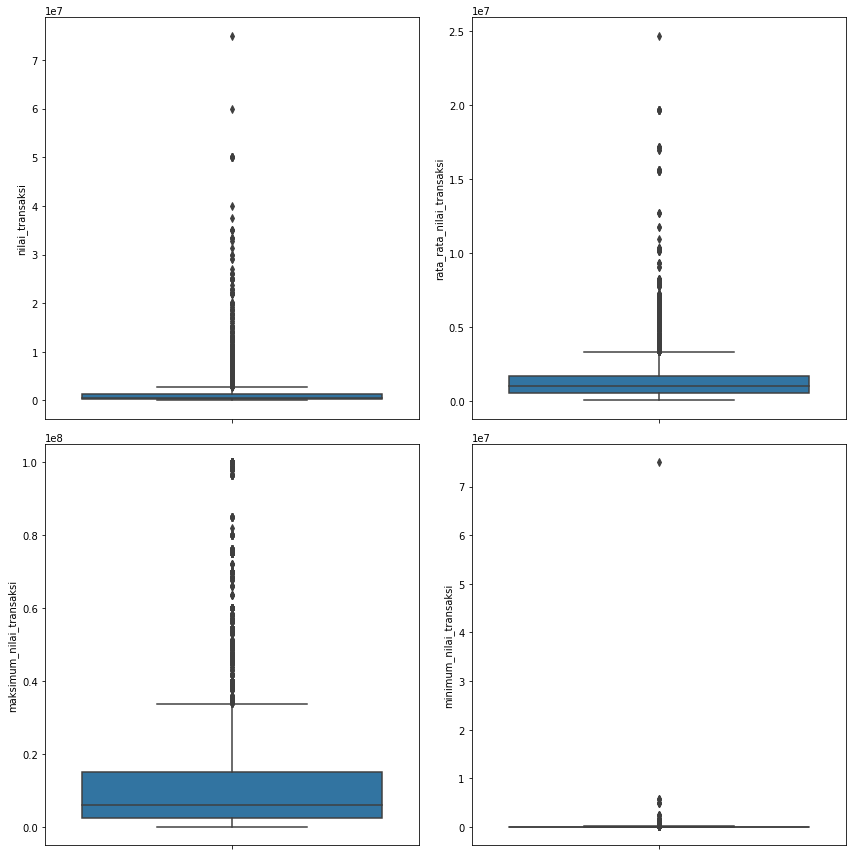

In [7]:
graphoutbox = datatrain[['nilai_transaksi','rata_rata_nilai_transaksi','maksimum_nilai_transaksi','minimum_nilai_transaksi', 'rata_rata_jumlah_transaksi']]
fig, axes = plt.subplots(round(len(graphoutbox.columns) / 2), 2, figsize=(12, 12))

for i, ax in enumerate(fig.axes):
    if i < len(graphoutbox.columns):
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
        sns.boxplot(y=graphoutbox.columns[i],data=graphoutbox, ax=ax)

fig.tight_layout()

In [8]:
import pprint
print("nilai_transaksi : ")
pprint.pprint(outlierRatio(datatrain.nilai_transaksi))
print("")
print("rata_rata_nilai_transaksi : ")
pprint.pprint(outlierRatio(datatrain.rata_rata_nilai_transaksi))
print("")
print("maksimum_nilai_transaksi : ")
pprint.pprint(outlierRatio(datatrain.maksimum_nilai_transaksi))
print("")
print("minimum_nilai_transaksi : ")
pprint.pprint(outlierRatio(datatrain.minimum_nilai_transaksi))
print("")
print("rata_rata_jumlah_transaksi : ")
pprint.pprint(outlierRatio(datatrain.rata_rata_jumlah_transaksi))

nilai_transaksi : 
{'mad_based_outlier': [802, '6.11%'],
 'outlierVote': [326, '2.48%'],
 'percentile_based_outlier': [654, '4.98%'],
 'std_div': [259, '1.97%']}

rata_rata_nilai_transaksi : 
{'mad_based_outlier': [0, '0.00%'],
 'outlierVote': [0, '0.00%'],
 'percentile_based_outlier': [0, '0.00%'],
 'std_div': [391, '2.98%']}

maksimum_nilai_transaksi : 
{'mad_based_outlier': [0, '0.00%'],
 'outlierVote': [0, '0.00%'],
 'percentile_based_outlier': [0, '0.00%'],
 'std_div': [727, '5.54%']}

minimum_nilai_transaksi : 
{'mad_based_outlier': [0, '0.00%'],
 'outlierVote': [0, '0.00%'],
 'percentile_based_outlier': [0, '0.00%'],
 'std_div': [12, '0.09%']}

rata_rata_jumlah_transaksi : 
{'mad_based_outlier': [0, '0.00%'],
 'outlierVote': [0, '0.00%'],
 'percentile_based_outlier': [0, '0.00%'],
 'std_div': [976, '7.44%']}


/home/notula/PycharmProjects/finhacks-data-bca/venv/lib/python3.5/site-packages/numpy/lib/function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/notula/PycharmProjects/finhacks-data-bca/venv/lib/python3.5/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: Invalid value encountered in median for 1 results
  r = func(a, **kwargs)
/home/notula/PycharmProjects/finhacks-data-bca/venv/lib/python3.5/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/home/notula/PycharmProjects/finhacks-data-bca/venv/lib/python3.5/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()


/home/notula/PycharmProjects/finhacks-data-bca/venv/lib/python3.5/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/notula/PycharmProjects/finhacks-data-bca/venv/lib/python3.5/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/notula/PycharmProjects/finhacks-data-bca/venv/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/notula/PycharmProjects/finhacks-data-bca/venv/

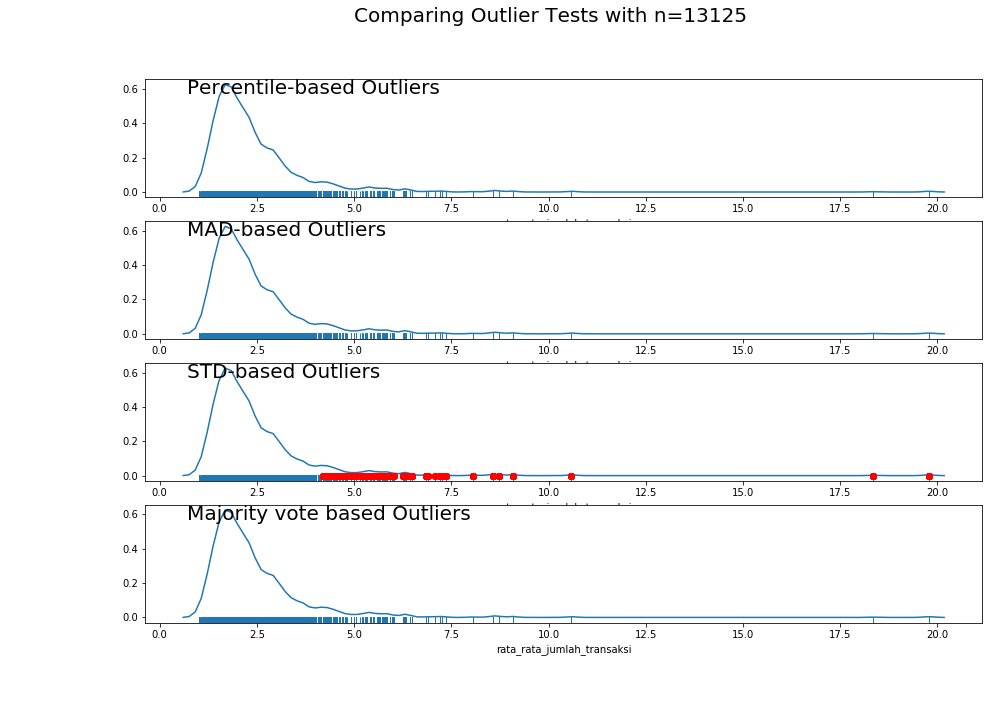

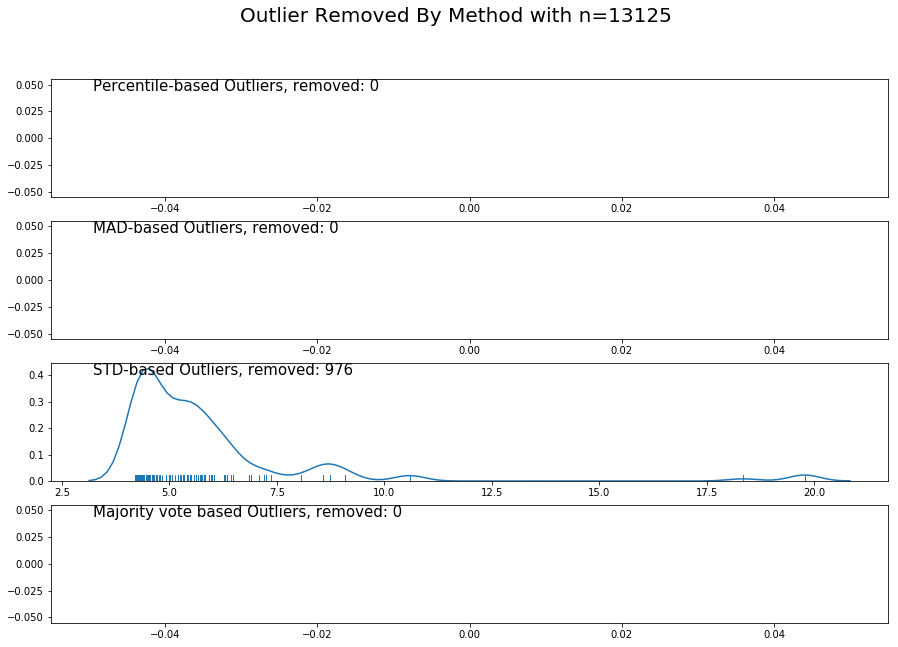

In [9]:
# datatrain.rata_rata_jumlah_transaksi.plot.box()
# ax = sns.boxplot(y=datatrain["rata_rata_jumlah_transaksi"])
plotOutlier(datatrain.rata_rata_jumlah_transaksi)
plotOutlierFree(datatrain.rata_rata_jumlah_transaksi)

In [11]:
newRatJumTrans = replaceOutlier(datatrain.rata_rata_jumlah_transaksi, replace='median')#'minUpper')
# newRatJumTrans

/home/notula/PycharmProjects/finhacks-data-bca/venv/lib/python3.5/site-packages/numpy/lib/function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/notula/PycharmProjects/finhacks-data-bca/venv/lib/python3.5/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: Invalid value encountered in median for 1 results
  r = func(a, **kwargs)
/home/notula/PycharmProjects/finhacks-data-bca/venv/lib/python3.5/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/home/notula/PycharmProjects/finhacks-data-bca/venv/lib/python3.5/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()


In [12]:
datatrain.head()

,X,id_tanggal_transaksi_awal,tanggal_transaksi_awal,tipe_kartu,id_merchant,nama_merchant,tipe_mesin,tipe_transaksi,nama_transaksi,nilai_transaksi,...,nama_channel,id_channel,flag_transaksi_finansial,status_transaksi,bank_pemilik_kartu,rata_rata_nilai_transaksi,maksimum_nilai_transaksi,minimum_nilai_transaksi,rata_rata_jumlah_transaksi,flag_transaksi_fraud
0,4676,2457646,2457726,111,-2,1798,2605127,26,10,2200000.0,...,1,9,False,3,999,1.332293e+06,9750000.0,10000.0,2.73,0
1,788,2457419,2457507,111,-2,1798,-3,156,12,2500000.0,...,5,8,False,3,999,1.369048e+06,10000000.0,30000.0,2.33,1
2,1520,2457521,2457612,2,-2,1798,-3,156,12,1200000.0,...,5,8,False,3,999,1.552346e+07,100000000.0,41804.0,2.40,0
3,9346,2457659,2457746,103,75336,249,2806174,58,6,320000.0,...,2,4,False,3,999,7.117647e+05,6884408.0,10000.0,1.98,0
4,2914,2457311,2457385,0,-2,1798,2334932,26,10,150000.0,...,1,9,False,3,999,6.179683e+05,2500000.0,100000.0,1.46,0


In [13]:
def removeOutliers(data, item):
    itemdata = data[item]
    asd = data[np.abs(itemdata-itemdata.mean()) <= (3*itemdata.std())]
    # keep only the ones that are within +3 to -3 standard deviations in the column 'Data'.

    itemdata = asd[item]
    asd = asd[~(np.abs(itemdata-itemdata.mean()) > (3*itemdata.std()))]
    # or if you prefer the other way around
    return asd

newdatatrain = removeOutliers(datatrain, 'rata_rata_jumlah_transaksi')
print(newdatatrain.shape)
# print(datatrain.shape)

newdatatrain = removeOutliers(newdatatrain, 'nilai_transaksi')
print(newdatatrain.shape)
# print(datatrain.shape)

newdatatrain = removeOutliers(newdatatrain, 'rata_rata_nilai_transaksi')
print(newdatatrain.shape)
# print(datatrain.shape)

newdatatrain = removeOutliers(newdatatrain, 'maksimum_nilai_transaksi')
print(newdatatrain.shape)
# print(datatrain.shape)

newdatatrain = removeOutliers(newdatatrain, 'minimum_nilai_transaksi')
print(newdatatrain.shape)
print(datatrain.shape)

(12594, 28)
(12042, 28)
(11631, 28)
(11075, 28)
(10622, 28)
(13125, 28)


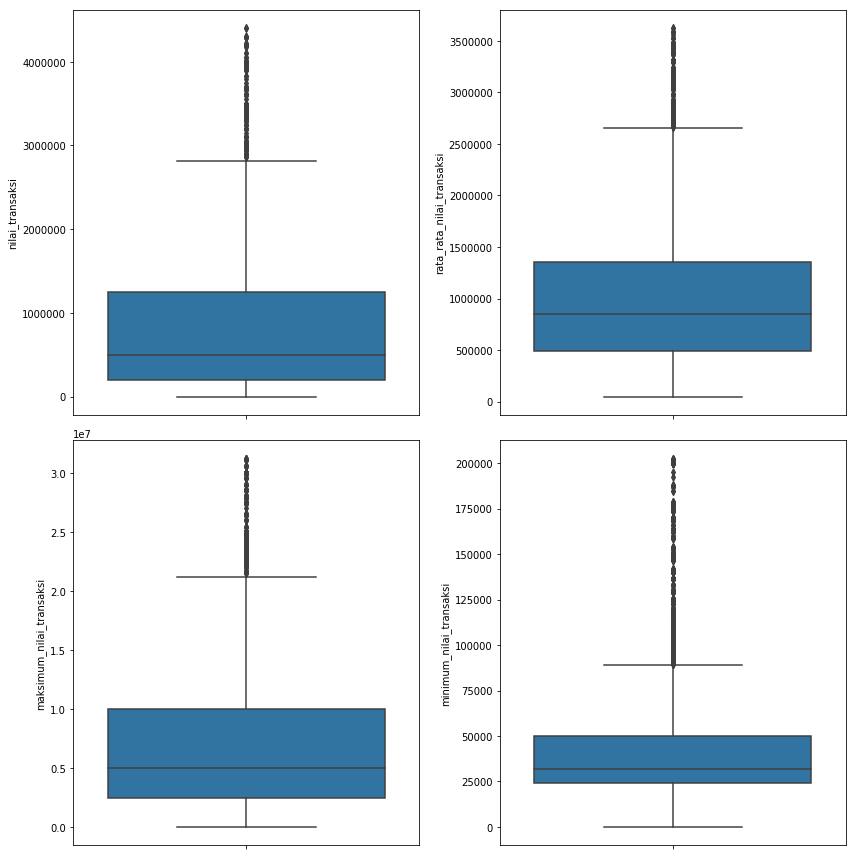

In [15]:
graphoutbox = newdatatrain[['nilai_transaksi','rata_rata_nilai_transaksi','maksimum_nilai_transaksi','minimum_nilai_transaksi', 'rata_rata_jumlah_transaksi']]
fig, axes = plt.subplots(round(len(graphoutbox.columns) / 2), 2, figsize=(12, 12))

for i, ax in enumerate(fig.axes):
    if i < len(graphoutbox.columns):
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
        sns.boxplot(y=graphoutbox.columns[i],data=graphoutbox, ax=ax)

fig.tight_layout()

### E. Dealing with Imbalanced Data


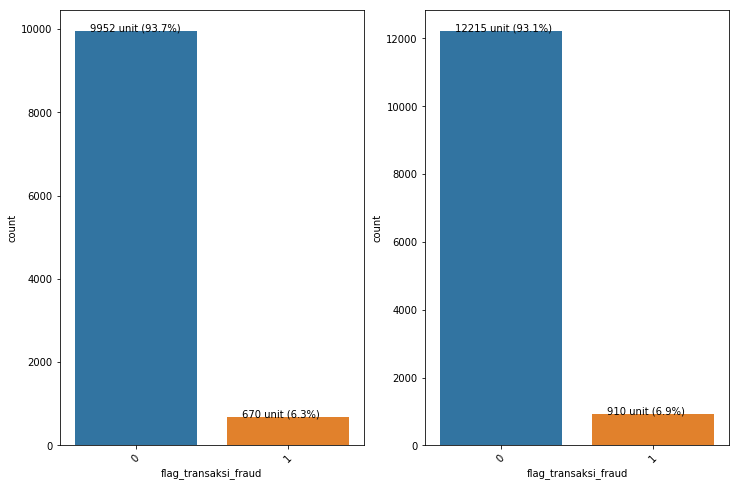

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12, 8))

ax = fig.axes[0]
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
sns.countplot(x="flag_transaksi_fraud", data=newdatatrain, ax=ax)
total = len(newdatatrain)
for p in ax.patches:
        ax.annotate('{} unit ({:.1f}%)'.format(p.get_height(), 100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))
# ax.title("flag_transaksi_fraud new data")

ax = fig.axes[1]
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
sns.countplot(x="flag_transaksi_fraud", data=datatrain, ax=ax)
total = len(datatrain)
for p in ax.patches:
        ax.annotate('{} unit ({:.1f}%)'.format(p.get_height(), 100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))
# ax.title("flag_transaksi_fraud old data")

#### Upsampling data

In [17]:
from sklearn.utils import resample
# Separate majority and minority classes
df_majority = newdatatrain[newdatatrain.flag_transaksi_fraud==0]
df_minority = newdatatrain[newdatatrain.flag_transaksi_fraud==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=9952,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.flag_transaksi_fraud.value_counts()
# 1    576
# 0    576
# Name: balance, dtype: int64

1    9952
0    9952
Name: flag_transaksi_fraud, dtype: int64

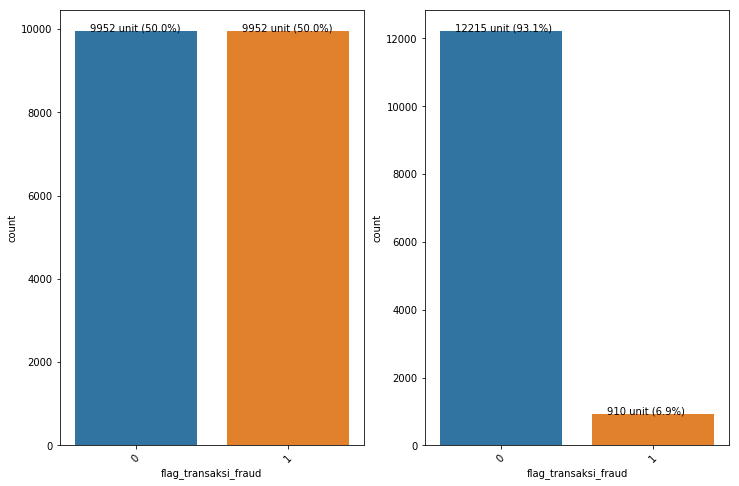

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(12, 8))

ax = fig.axes[0]
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
sns.countplot(x="flag_transaksi_fraud", data=df_upsampled, ax=ax)
total = len(df_upsampled)
for p in ax.patches:
        ax.annotate('{} unit ({:.1f}%)'.format(p.get_height(), 100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))
# ax.title("flag_transaksi_fraud new data")

ax = fig.axes[1]
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
sns.countplot(x="flag_transaksi_fraud", data=datatrain, ax=ax)
total = len(datatrain)
for p in ax.patches:
        ax.annotate('{} unit ({:.1f}%)'.format(p.get_height(), 100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))
# ax.title("flag_transaksi_fraud old data")

#### Downsampling data

In [19]:
# Separate majority and minority classes
df_majority = newdatatrain[newdatatrain.flag_transaksi_fraud==0]
df_minority = newdatatrain[newdatatrain.flag_transaksi_fraud==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=670,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.flag_transaksi_fraud.value_counts()
# 1    49
# 0    49
# Name: balance, dtype: int64

1    670
0    670
Name: flag_transaksi_fraud, dtype: int64

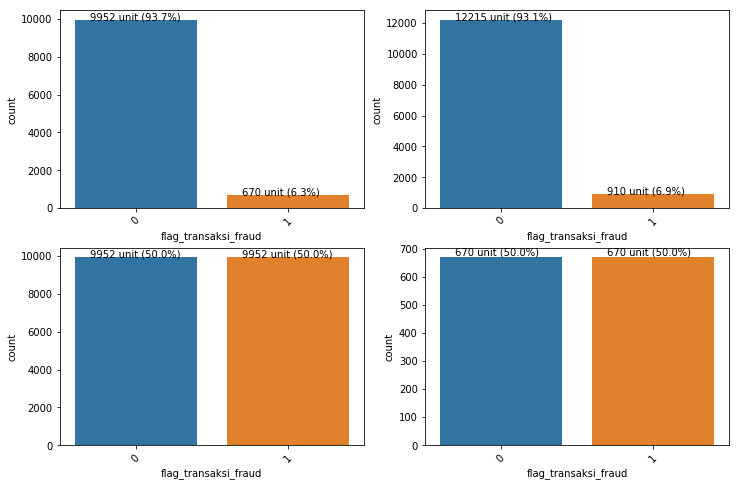

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

ax = fig.axes[0]
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
sns.countplot(x="flag_transaksi_fraud", data=newdatatrain, ax=ax)
total = len(newdatatrain)
for p in ax.patches:
        ax.annotate('{} unit ({:.1f}%)'.format(p.get_height(), 100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))
# ax.title("flag_transaksi_fraud new data")


ax = fig.axes[1]
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
sns.countplot(x="flag_transaksi_fraud", data=datatrain, ax=ax)
total = len(datatrain)
for p in ax.patches:
        ax.annotate('{} unit ({:.1f}%)'.format(p.get_height(), 100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))
# ax.title("flag_transaksi_fraud old data")


ax = fig.axes[2]
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
sns.countplot(x="flag_transaksi_fraud", data=df_upsampled, ax=ax)
total = len(df_upsampled)
for p in ax.patches:
        ax.annotate('{} unit ({:.1f}%)'.format(p.get_height(), 100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))
# ax.title("flag_transaksi_fraud old data")


ax = fig.axes[3]
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
sns.countplot(x="flag_transaksi_fraud", data=df_downsampled, ax=ax)
total = len(df_downsampled)
for p in ax.patches:
        ax.annotate('{} unit ({:.1f}%)'.format(p.get_height(), 100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))
# ax.title("flag_transaksi_fraud old data")

#### testing data model

## Feature selection


code:
1. https://www.kaggle.com/kanncaa1/feature-selection-and-data-visualization
1. https://machinelearningmastery.com/feature-selection-in-python-with-scikit-learn/
1. https://machinelearningmastery.com/feature-selection-machine-learning-python/
1. https://towardsdatascience.com/a-feature-selection-tool-for-machine-learning-in-python-b64dd23710f0

24 total column


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

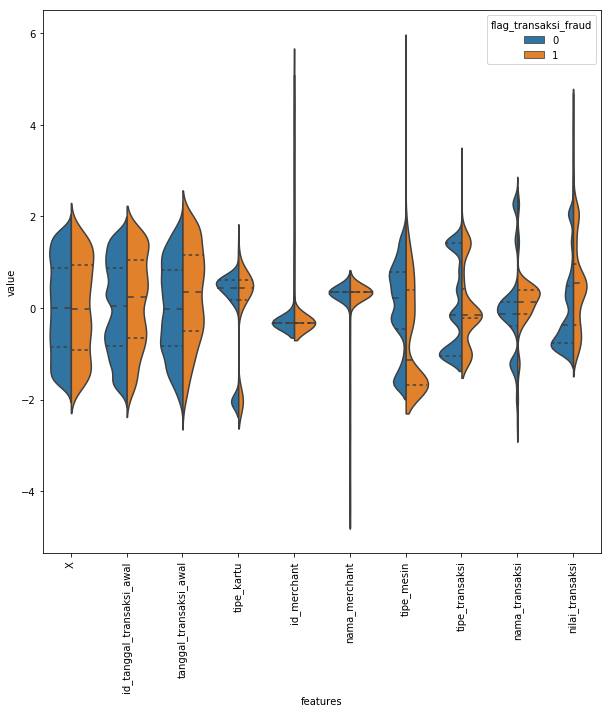

In [52]:
# y includes our labels and x includes our features
y = newdatatrain.flag_transaksi_fraud                          # M or B 
listt = ['flag_transaksi_fraud', 'flag_transaksi_finansial', 'status_transaksi', 'bank_pemilik_kartu']
x = newdatatrain.drop(listt,axis = 1 )
x.head()
print("{} total column".format(len(x.columns)))

# first ten features
data_dia = y
data = x
data_n_2 = (data - data.mean()) / (data.std())              # standardization
data = pd.concat([y,data_n_2.iloc[:,0:10]],axis=1)
data = pd.melt(data,id_vars="flag_transaksi_fraud",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(10,10))
sns.violinplot(x="features", y="value", hue="flag_transaksi_fraud", data=data,split=True, inner="quart")
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text xticklabel objects>)

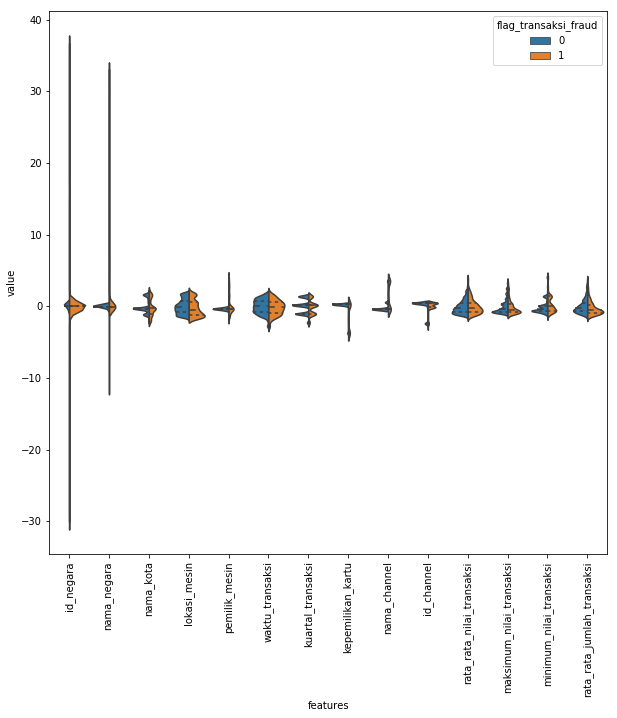

In [56]:
# Second ten features
data = pd.concat([y,data_n_2.iloc[:,10:24]],axis=1)
data = pd.melt(data,id_vars="flag_transaksi_fraud",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(10,10))
sns.violinplot(x="features", y="value", hue="flag_transaksi_fraud", data=data,split=True, inner="quart")
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text xticklabel objects>)

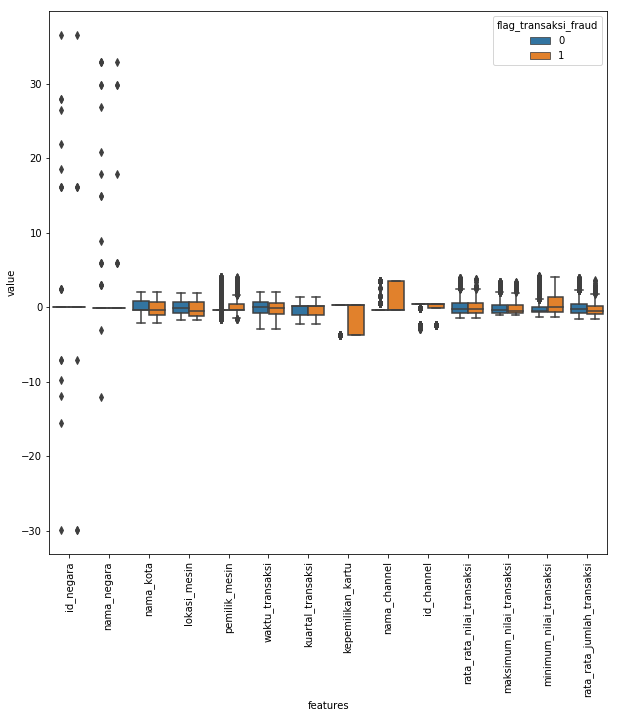

In [59]:
# As an alternative of violin plot, box plot can be used
# box plots are also useful in terms of seeing outliers
# I do not visualize all features with box plot
# In order to show you lets have an example of box plot
# If you want, you can visualize other features as well.
plt.figure(figsize=(10,10))
sns.boxplot(x="features", y="value", hue="flag_transaksi_fraud", data=data)
plt.xticks(rotation=90)

/home/notula/PycharmProjects/finhacks-data-bca/venv/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


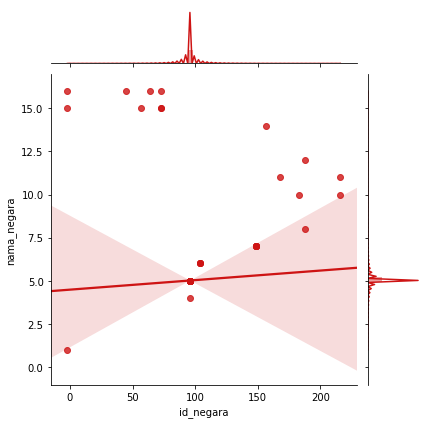

In [60]:
sns.jointplot(x.loc[:,'id_negara'], x.loc[:,'nama_negara'], kind="regg", color="#ce1414")

/home/notula/PycharmProjects/finhacks-data-bca/venv/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


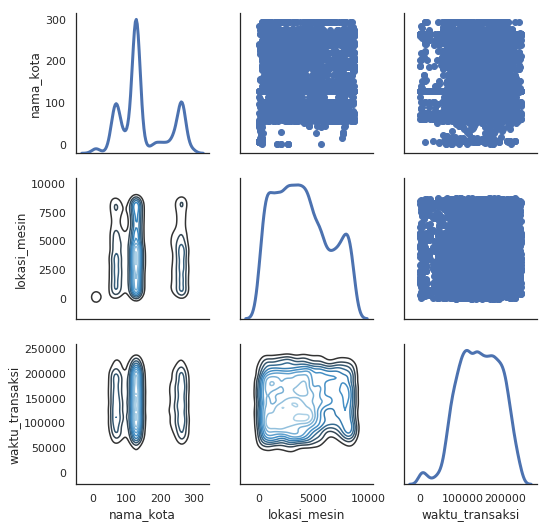

In [62]:
sns.set(style="white")
df = x.loc[:,['nama_kota','lokasi_mesin','waktu_transaksi']]
g = sns.PairGrid(df, diag_sharey=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot, lw=3)

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

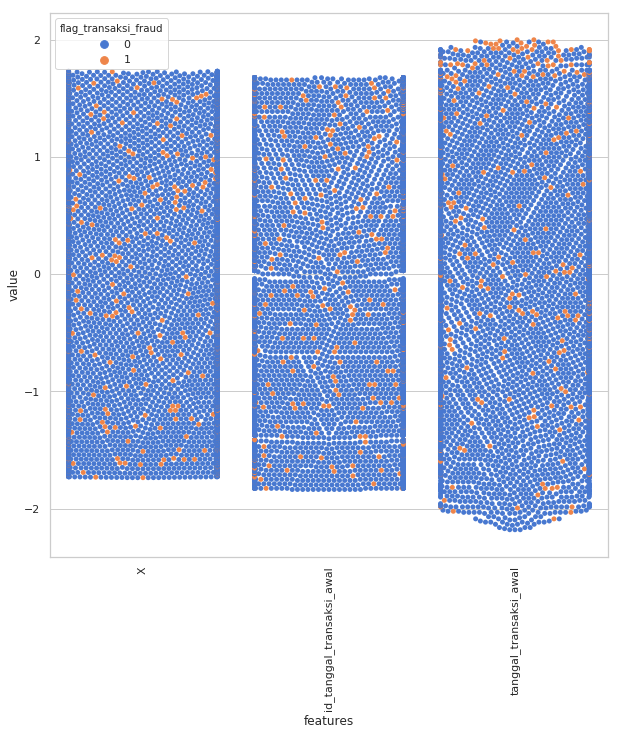

In [65]:
import time
sns.set(style="whitegrid", palette="muted")
data_dia = y
data = x
data_n_2 = (data - data.mean()) / (data.std())              # standardization
data = pd.concat([y,data_n_2.iloc[:,0:3]],axis=1)
data = pd.melt(data,id_vars="flag_transaksi_fraud",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(10,10))
tic = time.time()
sns.swarmplot(x="features", y="value", hue="flag_transaksi_fraud", data=data)

plt.xticks(rotation=90)

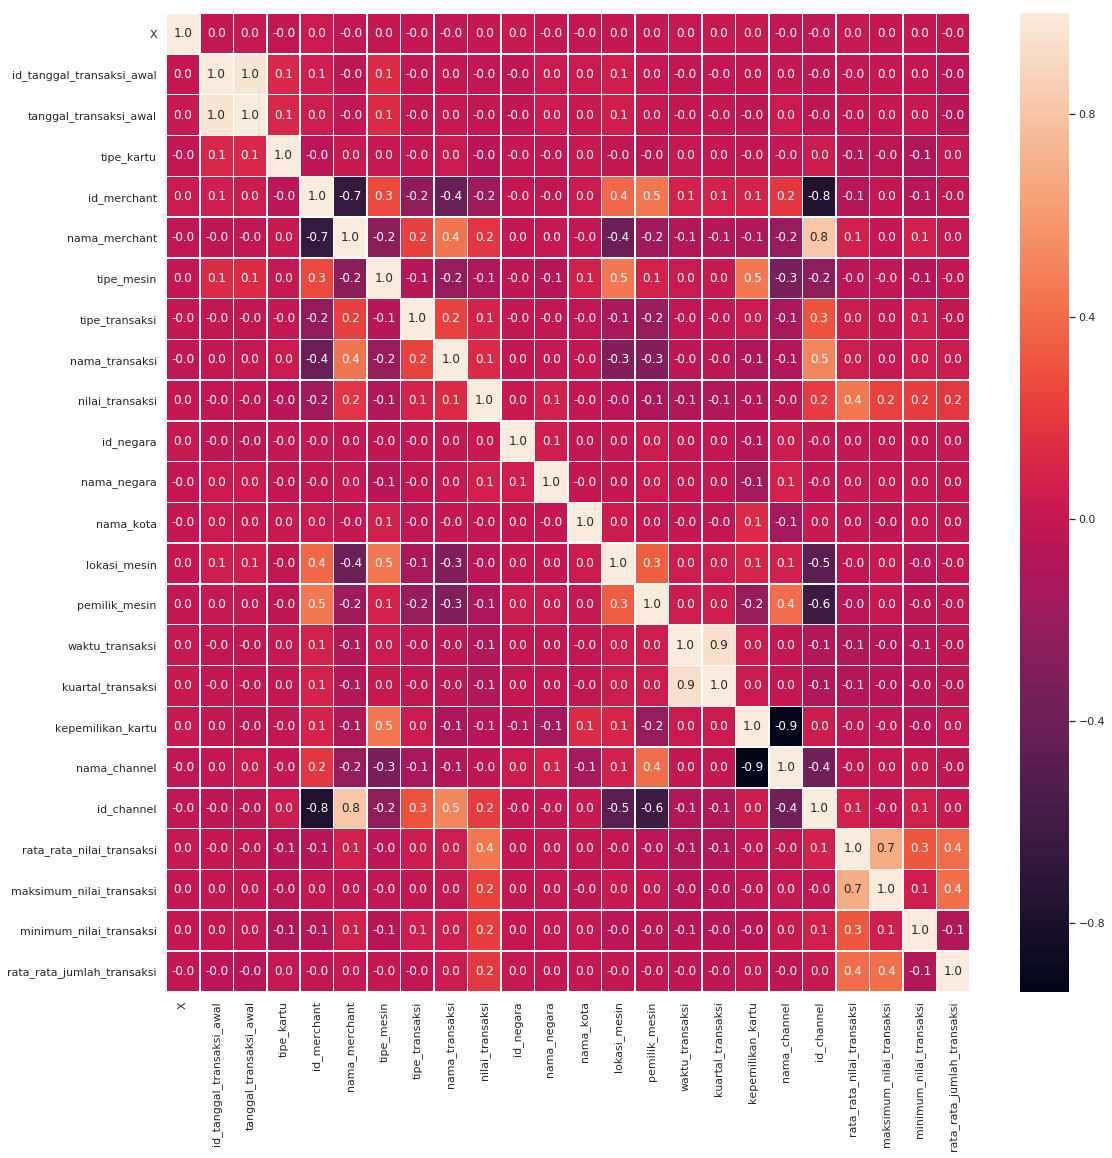

In [66]:
#correlation map
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(x.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

In [285]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

class TrainLogReg:
    def __init__(self, x_train, y_train, x_test, y_test):
        # def __init__(self, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test):
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.logreg = None
        self.predTrain = None
        self.predTest = None
        self.accTrainSet = None
        self.accTestSet = None

    def getDataDimention(self):
        print("Data train")
        print(self.x_train.shape)
        print("Data test")
        print(self.x_test.shape)

    def doTrain(self):
        self.logreg = LogisticRegression().fit(self.x_train, self.y_train)
#         self.logreg = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True,
#                             intercept_scaling=1, class_weight=None, random_state=7, solver='liblinear', max_iter=100,
#                             multi_class='ovr', verbose=2).fit(self.x_train, self.y_train)

    def doTest(self):
        # Predict on training set
        # Is our model still predicting just one class?
        # How's our accuracy?

        self.predTest = self.logreg.predict(self.x_test)
        print(np.unique(self.predTest))
        self.accTestSet = accuracy_score(self.y_test, self.predTest)
        print('Accuracy of logistic regression classifier on train set: {:.4f}'.format(self.accTestSet))
        print("\n")
        cm = confusion_matrix(self.y_test, self.predTest)
        sns.heatmap(cm, annot=True, fmt="d")

        self.predTrain = self.logreg.predict(self.x_train)
        print(np.unique(self.predTrain))
        self.accTrainSet = accuracy_score(self.y_train, self.predTrain)
        print('Accuracy of logistic regression classifier on test set: {:.4f}'.format(self.accTrainSet))
        print("\n")

        # cm = confusion_matrix(self.y_train, self.predTrain)
        # sns.heatmap(cm, annot=True, fmt="d")

    def getClassReport(self):
        # print('Report of logistic regression classifier on train set')
        # print(classification_report(self.y_train, self.predTrain))
        # print('\n')
        print('Report of logistic regression classifier on test set')
        print(classification_report(self.y_test, self.predTest))
        print("\n")

    def visROCTest(self):
        logit_roc_auc = roc_auc_score(self.y_test, self.logreg.predict(self.x_test))
        fpr, tpr, thresholds = roc_curve(self.y_test, self.logreg.predict_proba(self.x_test)[:, 1])
        plt.figure()
        plt.plot(fpr, tpr, label='Logistic Regression (area = %0.4f)' % logit_roc_auc)
        plt.plot([0, 1], [0, 1], 'r--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend(loc="lower right")
        plt.show()

    def getAccCrossFalidation(self):
        kfold = model_selection.KFold(n_splits=10, random_state=7)
        modelCV = LogisticRegression()
        scoring = 'accuracy'
        results = model_selection.cross_val_score(modelCV, self.x_train, self.y_train, cv=kfold, scoring=scoring)
        print("10-fold cross validation average accuracy: %.4f" % (results.mean()))
        print('\n')

    def getImportantFeature(self):
        try:
            # find best scored 5 features
            select_feature = SelectKBest(chi2, k=5).fit(self.x_train, self.y_train)
            print('Score list:', select_feature.scores_)
            print('Feature list:', self.x_train.columns)
        except:
            print("cannot get Important feature")

    def runAll(self):
        self.getDataDimention()
        self.doTrain()
        self.doTest()
        self.getAccCrossFalidation()
        self.getClassReport()
        self.visROCTest()
        self.getImportantFeature()

Data train
(19904, 27)
Data test
(13104, 27)
[0 1]
Accuracy of logistic regression classifier on train set: 0.6731


[0 1]
Accuracy of logistic regression classifier on test set: 0.6864


10-fold cross validation average accuracy: 0.5969


Report of logistic regression classifier on test set
             precision    recall  f1-score   support

          0       0.97      0.67      0.79     12210
          1       0.13      0.69      0.22       894

avg / total       0.91      0.67      0.75     13104





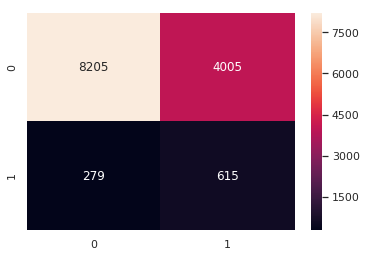

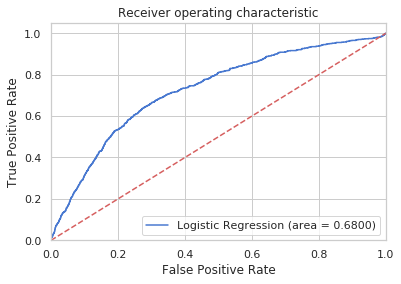

cannot get Important feature


In [225]:
y = df_upsampled.flag_transaksi_fraud
X = df_upsampled.drop('flag_transaksi_fraud', axis=1)
datatest = datatest.dropna()
y_test = datatest.flag_transaksi_fraud
X_test = datatest.drop('flag_transaksi_fraud', axis=1)

logreg = TrainLogReg(X, y, X_test, y_test)
logreg.runAll()

Data train
(1340, 27)
Data test
(13104, 27)
[0 1]
Accuracy of logistic regression classifier on train set: 0.6713


[0 1]
Accuracy of logistic regression classifier on test set: 0.6888


10-fold cross validation average accuracy: 0.6007


Report of logistic regression classifier on test set
             precision    recall  f1-score   support

          0       0.97      0.67      0.79     12210
          1       0.13      0.69      0.22       894

avg / total       0.91      0.67      0.75     13104





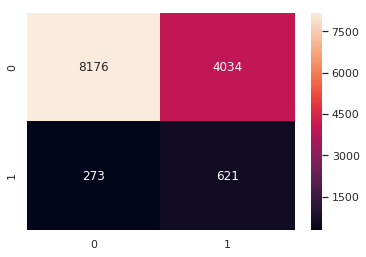

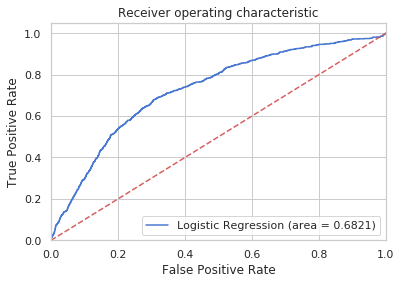

cannot get Important feature


In [226]:
y = df_downsampled.flag_transaksi_fraud
X = df_downsampled.drop('flag_transaksi_fraud', axis=1)
datatest = datatest.dropna()
y_test = datatest.flag_transaksi_fraud
X_test = datatest.drop('flag_transaksi_fraud', axis=1)

logreg = TrainLogReg(X, y, X_test, y_test)
logreg.runAll()

Data train
(13104, 27)
Data test
(13104, 27)
[0 1]
Accuracy of logistic regression classifier on train set: 0.9320


[0 1]
Accuracy of logistic regression classifier on test set: 0.9320


10-fold cross validation average accuracy: 0.9319


Report of logistic regression classifier on test set
             precision    recall  f1-score   support

          0       0.93      1.00      0.96     12210
          1       0.57      0.01      0.03       894

avg / total       0.91      0.93      0.90     13104





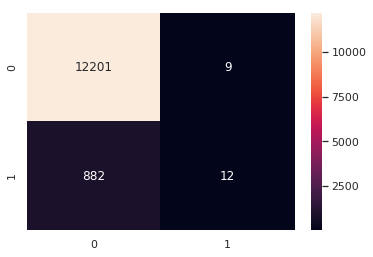

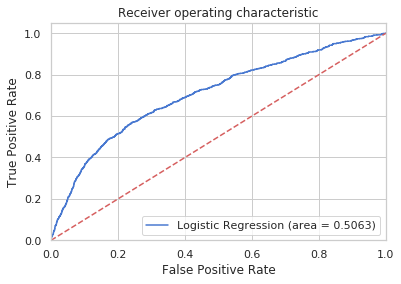

cannot get Important feature


In [223]:
nd = datatrain.dropna()
y = nd.flag_transaksi_fraud
X = nd.drop('flag_transaksi_fraud', axis=1)
datatest = datatest.dropna()
y_test = datatest.flag_transaksi_fraud
X_test = datatest.drop('flag_transaksi_fraud', axis=1)

logreg = TrainLogReg(X, y, X_test, y_test)
logreg.runAll()

(10622, 10)
(13104, 10)
Data train
(10622, 10)
Data test
(13104, 10)
[0 1]
Accuracy of logistic regression classifier on train set: 0.9310


[0]
Accuracy of logistic regression classifier on test set: 0.9369


10-fold cross validation average accuracy: 0.9369


Report of logistic regression classifier on test set
             precision    recall  f1-score   support

          0       0.93      1.00      0.96     12210
          1       0.38      0.02      0.03       894

avg / total       0.90      0.93      0.90     13104





/home/notula/PycharmProjects/finhacks-data-bca/venv/lib/python3.5/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


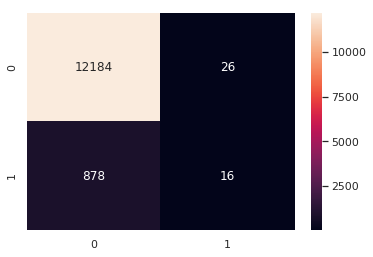

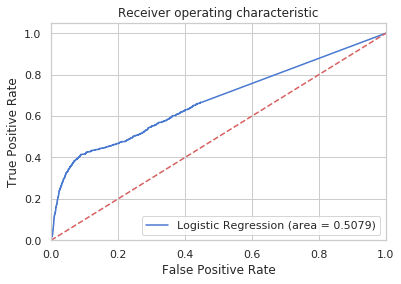

Score list: [2.48877399e+01 2.86744929e-01 2.24137291e+05 1.49544293e+08
 5.34205339e+04 2.63784370e+05 8.28706418e+02 4.96624719e+03
 3.57841425e+07 1.24016326e+01]
Feature list: Index(['X', 'tanggal_transaksi_awal', 'tipe_mesin', 'nilai_transaksi',
       'lokasi_mesin', 'waktu_transaksi', 'nama_channel',
       'rata_rata_nilai_transaksi', 'maksimum_nilai_transaksi',
       'rata_rata_jumlah_transaksi'],
      dtype='object')


In [313]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
newdatatrain['tipe_mesin'] = le.fit_transform(newdatatrain['tipe_mesin'].values.tolist())

listt = ['flag_transaksi_fraud', 'flag_transaksi_finansial', 'status_transaksi', 'bank_pemilik_kartu', 'id_tanggal_transaksi_awal', 'id_merchant', 'tipe_transaksi', 'id_channel', 'id_negara', 'nama_negara', 'pemilik_mesin', 'nama_merchant', 'kuartal_transaksi', 'tipe_kartu', 'nama_transaksi', 'kepemilikan_kartu', 'minimum_nilai_transaksi', 'nama_kota']
# listt = []
x_1 = newdatatrain.drop(listt, axis = 1)
y_1 = newdatatrain.flag_transaksi_fraud
print(x_1.shape)

datatest = datatest.dropna()
x_1_test = datatest.drop(listt, axis = 1)
y_1_test = datatest.flag_transaksi_fraud
print(x_1_test.shape)

x_train = x_1
x_test = x_1_test
y_train = y_1
y_test = y_1_test

logreg = TrainLogReg(x_train, y_train, x_test, y_test)
logreg.runAll()

### Recursive feature elimination (RFE) with random forest

In [314]:
print(x_train.shape)
from sklearn.feature_selection import RFE
# Create the RFE object and rank each pixel
clf_rf_3 = RandomForestClassifier()      
rfe = RFE(estimator=logreg.logreg, n_features_to_select=7, step=1)
rfe = rfe.fit(x_train, y_train)
print('Chosen best 5 feature by rfe:',x_train.columns[rfe.support_])
rfe.ranking_#.support_

(10622, 10)
Chosen best 5 feature by rfe: Index(['X', 'tanggal_transaksi_awal', 'tipe_mesin', 'nilai_transaksi',
       'lokasi_mesin', 'waktu_transaksi', 'nama_channel'],
      dtype='object')


array([1, 1, 1, 1, 1, 1, 1, 2, 4, 3])

In [315]:
from sklearn.feature_selection import RFECV

# The "accuracy" scoring is proportional to the number of correct classifications
clf_rf_4 = RandomForestClassifier() 
rfecv = RFECV(estimator=clf_rf_4, step=1, cv=18,scoring='accuracy')   #5-fold cross-validation
rfecv = rfecv.fit(x_train, y_train)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', x_train.columns[rfecv.support_])

Optimal number of features : 10
Best features : Index(['X', 'tanggal_transaksi_awal', 'tipe_mesin', 'nilai_transaksi',
       'lokasi_mesin', 'waktu_transaksi', 'nama_channel',
       'rata_rata_nilai_transaksi', 'maksimum_nilai_transaksi',
       'rata_rata_jumlah_transaksi'],
      dtype='object')


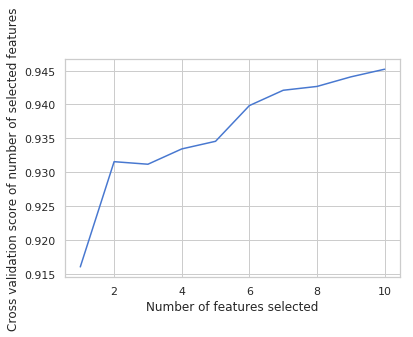

[0.91602612 0.93155824 0.93118222 0.93343988 0.93456887 0.93984099
 0.94210119 0.94266648 0.9440794  0.94520934]
set()


In [316]:
# Plot number of features VS. cross-validation scores
import matplotlib.pyplot as plt
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

print(rfecv.grid_scores_)
print(set(x_train.columns).difference(x_train.columns[rfecv.support_]))

Feature ranking:
1. feature 3 (0.117545)
2. feature 2 (0.114598)
3. feature 1 (0.112471)
4. feature 0 (0.109228)
5. feature 9 (0.098829)
6. feature 8 (0.096674)
7. feature 5 (0.094673)
8. feature 7 (0.091980)
9. feature 4 (0.090173)
10. feature 6 (0.073830)


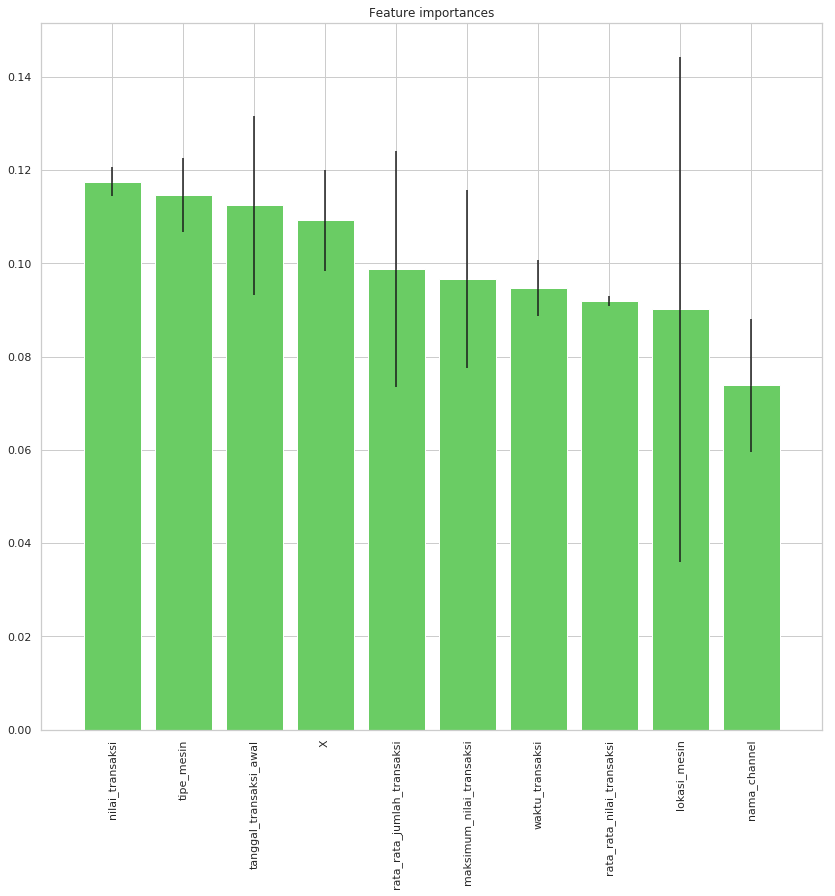

In [317]:
clf_rf_5 = RandomForestClassifier()      
clr_rf_5 = clf_rf_5.fit(x_train,y_train)
importances = clr_rf_5.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(x_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest

plt.figure(1, figsize=(14, 13))
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), importances[indices],
       color="g", yerr=std[indices], align="center")
plt.xticks(range(x_train.shape[1]), x_train.columns[indices],rotation=90)
plt.xlim([-1, x_train.shape[1]])
plt.show()

Text(0,0.5,'explained_variance_ratio_')

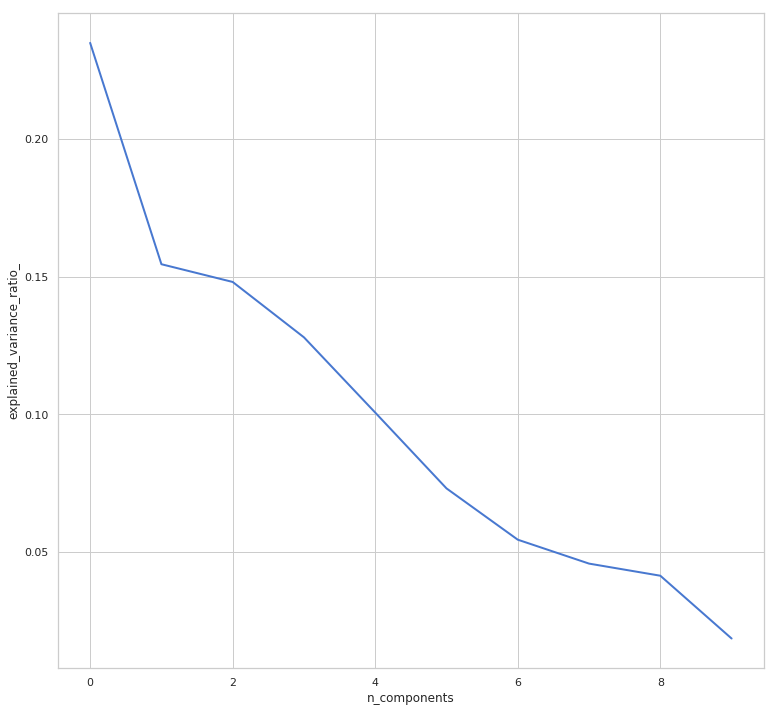

In [319]:
# # split data train 70 % and test 30 %
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
#normalization
x_train_N = (x_train-x_train.mean())/(x_train.max()-x_train.min())
x_test_N = (x_test-x_test.mean())/(x_test.max()-x_test.min())

from sklearn.decomposition import PCA
pca = PCA()
pca.fit(x_train_N)

plt.figure(1, figsize=(14, 13))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_ratio_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio_')